# Distinguish cardiologists from the general providers
### Author: Weiwei Ouyang
### Date: 01/12/2020

### Dataset:
* **npi_proc_counts.csv(Medicare Procedure Claims)**
* **npi_drugs.csv(Medicare Pharmacy Claims)**
* **hcpcs_lookup.csv(HCPCS codes)**
* **npi_specialty.csv (Provider type)**

### Steps:
* **Load the packages and the raw tables (4 tables)**
* **Preprocess npi_specialty table and get the outcomes (Whether cardiologist or not)**
* **Preprocess the procedure claim (Get the procedure group features and corresponding average service numbers)**
* **Preprocess the pharmacy claim (Get the procedure group features and corresponding average drug numbers)**
* **Get the merged table with outcomes and corresponding procedure and drug columns**
* **Feature Analysis, Engineering and Selection**
* **Apply Machine Learning Methods and Model Comparisons and Evaluations**
* **Conclusion and Discussions**

## Load the packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from pandas_ply import install_ply, X, sym_call #Similar funtion like %>% in R
import multiprocessing
from multiprocessing import Pool, cpu_count  ##Paralel Computing
install_ply(pd)

## Load the datasets

In [2]:
claim = pd.read_csv('npi_proc_counts.csv')
rx_claim=pd.read_csv('npi_drugs.csv')
HCPC=pd.read_csv('hcpcs_lookup.csv')
provider=pd.read_csv('npi_specialty.csv')

## Preprocess the outcome dataset

Since we want to distinguish cardiologists from others, we can transform it to a binary classification problem and generate a new column to indicate whether this provider is cardiologist or not

**Generate a new column 'cardi_flag' to indicate whether the provider is cardiologist and drop duplicates**

In [3]:
provider['cardi_flag']=provider.specialty.str.contains('Cardiology').astype(int)
provider.drop_duplicates(inplace=True)

**Calculate the rate of cardiologist**

In [4]:
print("In total, there are {} providers and {}% are cardiologists".format(provider.shape[0],provider.cardi_flag.mean()*100))

In total, there are 909605 providers and 2.475140308155738% are cardiologists


2.48% of all providers are cardiologists. 

In [5]:
#only keep the flag column and the NPI code as primary key to join other tables later
provider=provider[['NPI','cardi_flag']]

In [6]:
#provider.shape
#provider.NPI.nunique() 
#Check whether NPI is unique and there are no duplicate NPI codes

In [7]:
provider.head(3)

,NPI,cardi_flag
0,1003000126,0
1,1003000134,0
2,1003000142,0


**provider** can be our main table and left join other tables. To narrow down the procedure and drug types, we only keep the procedures and drugs that cardiologists used and narrow down the columns in the datatable.

## Preprocess the claim data(long-format to wide-format)

There are too many procedures in procedure claim table and we narrow down to the most common procedures cardiologists will have. Below are the following steps(In practice, B and C can reverse order sometimes):

**A. Narrow down to procedures cardiologists would have.**

**B.Generate wide-format table with colums contain all procedures and corresponding procedure numbers.**

**C.Choose a cut-off and only choose the most common single procedures.**

**D.Use clinical domain knowledge to generate aggrigate fianl features for modeling (HCPC table).**

In [8]:
print('In total, there are {} unique procedures in claim table while the numbers of unique procedures among cardiologists are {}'.format(claim.HCPCS_CODE.nunique(),claim[claim.NPI.isin(provider[provider.cardi_flag==1].NPI)].HCPCS_CODE.nunique()))

In total, there are 5983 unique procedures in claim table while the numbers of unique procedures among cardiologists are 1339


### A. Narrow down to procedures cardiologists would have

In [9]:
%%time
claim=claim[claim.HCPCS_CODE.isin(list(set(claim[claim.NPI.isin(provider[provider.cardi_flag==1].NPI)].HCPCS_CODE)))]

CPU times: user 1.06 s, sys: 316 ms, total: 1.38 s
Wall time: 1.38 s


The total numbers for each procedure may depend on the number of members who received the service. Thus we are more interesetd in the average number of services one member received for each service.

**Remove duplicates**

In [10]:
#claim.drop_duplicates()
#claim.shape
# There exist duplicates. 7899575----> 7898099
claim=claim.drop_duplicates()

In [11]:
claim.shape

(7898099, 4)

**Calculate the average number for each procedure (Get long-format table)**

In [13]:
claim_long=claim.groupby(['NPI','HCPCS_CODE']).ply_select(AVG_SRVC=X.LINE_SRVC_CNT.sum()/X.BENE_UNIQUE_CNT.sum(),
                                                         SRVC_Count=X.LINE_SRVC_CNT.sum(),
                                                         MEMBER_Count=X.BENE_UNIQUE_CNT.sum()).reset_index()
claim_long.head(3)

,NPI,HCPCS_CODE,AVG_SRVC,SRVC_Count,MEMBER_Count
0,1003000126,99222,1.028986,142,138
1,1003000126,99223,1.010526,96,95
2,1003000126,99231,1.297872,61,47


In [14]:
del claim

In [15]:
#claim[claim.HCPCS_CODE.str.contains('[A-Z]')].HCPCS_CODE

**B. Generate wide-format table with colums contain all procedures and corresponding procedure numbers**

In [15]:
%%time
claim_wide_Avg=claim_long.pivot(index='NPI', columns='HCPCS_CODE', values='AVG_SRVC')
#claim_wide_SRVC=claim_long.pivot(index='NPI', columns='HCPCS_CODE', values='SRVC_Count')
#claim_wide_MEMBER=claim_long.pivot(index='NPI', columns='HCPCS_CODE', values='MEMBER_Count')

CPU times: user 26.4 s, sys: 32.9 s, total: 59.3 s
Wall time: 1min 3s


In [16]:
claim_wide_Avg.head(1)

HCPCS_CODE,00142,00300,00320,00400,00410,00537,00541,00560,00562,00567,...,Q2039,Q3014,Q4102,Q9956,Q9957,Q9963,Q9965,Q9966,Q9967,Q9969
NPI,,,,,,,,,,,,,,,,,,,,,
1003000126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are many missing values in each columns, next we need to filter the procedure with too many missing rows(At least Non-Missing>=2.5%). Missing values mean the provider didn't apply this procedure. The reason we choose 2.5% as cut-off due to the cardilogist rate. 

**Generate Non-Missing value percentage table**

In [17]:
%%time
#Miss=claim_wide.isnull().sum(axis=0)
Miss=pd.DataFrame([(x,y) for x,y in claim_wide_Avg.isnull().sum(axis=0).items()],columns=['HCPCS_CODE','Miss_Count'])
Miss['Non_Miss_Per']=1-Miss['Miss_Count']/claim_wide_Avg.shape[0]
#Keep_Proc=list(Miss[Miss.Miss_Per<0.05].HCPCS_CODE)

CPU times: user 12.7 s, sys: 13.1 s, total: 25.8 s
Wall time: 30.5 s


In [18]:
Miss.head(1)

,HCPCS_CODE,Miss_Count,Non_Miss_Per
0,00142,813427,0.027703


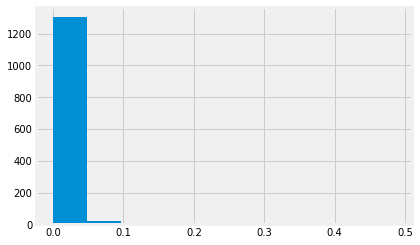

In [19]:
Miss.Non_Miss_Per.hist()

If we look at procedure one by one, the majority of non-missing percentage is smaller than 10%. 

### C. Choose a cut-off and only choose the most common single procedures

If we consider procedure one by one, we need to filter the procedure with too many missing rows(At least Non-Missing>=2.5%). The reason we choose 2.5% as cut-off due to the cardilogist rate (2.48%). 

**Show the procedures with non-missing percentage no smaller than 2.5%**

In [20]:
pd.set_option('display.max_rows', None)
Keep_Procedure=list(Miss[Miss.Non_Miss_Per>=0.025].HCPCS_CODE)
HCPC[HCPC.HCPCS_CODE.isin(Keep_Procedure)].sort_index()

,HCPCS_CODE,HCPCS_DESCRIPTION
6,00142,Anesthesia for lens surgery
62,00740,Anesthesia for procedure on gastrointestinal t...
76,00810,Anesthesia for procedure on lower intestine us...
436,17000,Destruction of skin growth
531,20610,Aspiration or injection of large joint or join...
1601,36415,Insertion of needle into vein for collection o...
2943,69210,Removal of impact ear wax
3010,70450,CT scan head or brain
3040,71010,"X-ray of chest, 1 view, front"
3042,71020,"X-ray of chest, 2 views, front and side"


In [21]:
print('There are {} procedures with non-missing percentage no smaller than 2.5% and displayed above'.format(len(Keep_Procedure)))

There are 78 procedures with non-missing percentage no smaller than 2.5% and displayed above


### D. Use clinical domain knowledge to generate final aggrigate features for modeling (HCPC table)

The assumption we use here is: The higher the non-missing percentage is, the more commonly applied the procedures would be by providers. 

Since we don't have lots of clinical domain knowledge, we can use the 78 procedures we get in **Section C** to have an general understanding of what procedures the providers may have. From the table above, we can aggregate all to the following up procedure categories that may be useful for folow-up modeling step:


| Feature       | Description                            | Generation                                                                                                                |
|---------------|----------------------------------------|---------------------------------------------------------------------------------------------------------------------------|
| Anes          | Anesthesia |     See additonal note                                                                                                                 |
| skin          | Destruction of skin growth             | ['17000','17003','17004','17106','17107','17108','17110','17111']                                                         |
| Asp           | Aspiration or injection                | ['20600','20605','20610','20612','20615']                                                                                 |
| Insert_Vein   | Insertion of needle into vein          | ['36410','36415']                                                                                                         |
| Ear           | Removal of ear-related parts           | ['69110','69120','69140','69145','69200','69205','69210']                                                                 |
| CT_head       | CT scan head-related parts             | ['70450','70460','70470']                                                                                                 |
| Xray_chest    | X-ray of chest                         | ['71010','71015','71020','71021','71022','71023','71030','71034','71035']                                                 |
| Xray_spline   | X-ray of spline-related parts          | ['72010','72020','72040','72050','72052','72069','72070','72072','72074','72080','72090','72100','72110','72114','72120'] |
| Xray_pelvis   | X-ray of pelvis parts                  | ['72170','72190']                                                                                                         |
| Xray_shoulder | X-ray of shoulder                      | ['73010','73020','73030']                                                                                                 |
| Xray_hip      | X-ray of hip parts                     | ['73500','73510','73520','73525','73530','73540']                                                                         |
| Xray_knee     | X-ray of knee parts                    | ['73560','73562','73564','73565','73580']                                                                                 |
| Xray_ankle    | X-ray of ankle parts                   | ['73600','73610','73615']                                                                                                 |
| Xray_foot     | X-ray of foot parts                    | ['73620','73630']                                                                                                         |
| Xray_abd      | X-ray of abdomen                       | ['74000','74010','74020','74022']                                                                                         |
| CT_abd        | CT scan of abdomen                     | ['74150','74160','74170','74176','74177','74178']                                                                         |
| Ultra_g       | Ultrasonic guidance                    |['76930','76932','76936','76937','76940','76942','76950','76965','76998']                                                                                           |
| Inject_T      | Injection Tissue Related               | ['96372','96373','96374','96375','96379']                                                                                 |
| Bone          | Bone Related                           | ['77078','77080','77081','77082','77084']                                                                                 |
| BT            | Blood Test                             | ['80047','80048','80051','80053','80061']                                                                                 |
| Urine         | Urine test                             | ['81000','81001','81002','81003','81005','81007','81015','81020','81025','81050','81099']                                 |
| Hemo          | Hemoglobin Related                     | ['83020','83021','83026','83036','83037']                                                                                 |
| BT_TSH        | Blood test TSH                         | ['84443']                                                                                                                 |
| B_Count       | Blood Cell Count                       | ['85025','85027']                                                                                                         |
| BT_Clot       | Blood Test clotting time               | ['85610','85611']                                                                                                         |
| Vac_influ     | Vaccine for influenza virus            | ['90653','90654','90655','90656','90657','90660','90661','90662']                                                         |
| Vac_pneu      | Vaccine for pneumococcal               | ['90732']                                                                                                                 |
| EKG           | Routine EKG                            | ['93000','93005','93010']                                                                                                 |
| Ultra_heart   | Ultrasound Exam of Heart-related parts | ['93303','93304','93306','93307','93308']                                                                                 |
| Ultra_head    | Ultrasound Exam of head-related parts  | ['93880','93882','93886','93888']                                                                                         |
| Ultra_arm     | Ultrasound Exam of arms or legs        | ['93965','93970','93971']                                                                                                 |
| Inject_prev   | Injection for prevention               | ['96372','96373','96374','96375','96379']                                                                                 |
| Phy_therapy   | Physical therapy evaluation            | ['97001','97002']                                                                                                         |
| Ther_Ex       | Therapeutic exercise                   | ['97110','97112','97113','97116','97124','97139','97140','97150','97530']                                                            |
| New_OP        | New Outpatient Visits                  | ['99201','99202','99203','99204','99205']                                                                                 |
| Est_OP        | Established Outpatient visits          | ['99211','99212','99213','99214','99215']                                                                                 |
| Hos_care      | Hospital obeservation care             | ['99217','99218','99219','99220']                                                                                         |
| Ini_IP        | Initial Inpatient Care                 | ['99221','99222','99223']                                                                                                 |
| Sub_IP        | Subsequent hospital inpatient care     | ['99231','99232','99233']                                                                                                 |
| Hos_Dis       | Hospital Discharge manage              | ['99238','99239']                                                                                                         |
| ED            | Emergency visits                       | ['99281','99282','99283','99284','99285']                                                                                 |
| CD            | Critical care delivery                 | ['99291','99292']                                                                                                         |
| Ini_Nurse     | Initial nursing visit                  | ['99304','99305','99306']                                                                                                 |
| Sub_Nurse     | Subsequent nursing visit               | ['99307','99308','99309','99310']                                                                                         |
| Admin_Vac     | Administration of vaccine              | ['G0008','G0009','G0010']                                                                                                 |
| Cervial       | Cervial Cancer Screen                  | ['G0101']                                                                                                                 |
| Home          | Home health                            | ['G0179','G0180','G0181','G0182']                                                                                         |
| Wellness      | Annual wellness visit                  | ['G0438','G0439']                                                                                                         |
| Triamc        | Injection of triamcinolone-related     | ['J3300','J3301','J3302','J3303']                                                                                         |
| Influ_Vac     | Influenza virus vaccine                | ['Q2034','Q2035','Q2036','Q2037','Q2038','Q2039']                                                                         |

Additonal Note:

['00100','00103','00104','00120','00126','00140','00142','00144','00145','00147','00148','00160','00164','00170','0190','00210','00211','00216','00220','00222','00300','00320','00350','00352','00400','00402','00404','00406','00410','00500','00520','00522','00528','00529','00530','00532','00534','00537','00540','00541','00542','00550','00560','00562','00563','00566','00567','00580','00600','00604','00620','00630','00635','00640','00670','00700',
'00702','00730','00740','00750','00752','00770','00790','00792','00794','00796','00797','00800','00810','00820',
'00830','00832','00840','00844','00846','00860','00862','00864','00865','00868','00870','00872','00873','00880',
'00882','00902','00904','00910','00912','00914','00916','00918','00920','00938','00940','00942','00944','00952',
'01112','01120','01160,'01170','01200','01202','01210','01214','01215','01220','01230','01232,'01250','01260','01270','01272','01320','01380','01382','01392','01400','01402','01430','01462','01470','01474','01480','01482','01486',
'01500','01520','01610','01620','01622','01630','01638','01670,'01710','01716'] 

**Generate raw aggregate feature dictionary**

In [89]:
Raw_Agg_Feature_dic={
'Anes':['00100','00103','00104','00120','00126','00140','00142','00144','00145','00147','00148','00160','00164','00170','00190','00210','00211','00216','00220','00222','00300','00320','00350','00352','00400','00402','00404','00406','00410','00500','00520','00522','00528','00529','00530','00532','00534','00537','00540','00541','00542','00550','00560','00562','00563','00566','00567','00580','00600','00604','00620','00630','00635','00640','00670','00700', '00702','00730','00740','00750','00752','00770','00790','00792','00794','00796','00797','00800','00810','00820', '00830','00832','00840','00844','00846','00860','00862','00864','00865','00868','00870','00872','00873','00880', '00882','00902','00904','00910','00912','00914','00916','00918','00920','00938','00940','00942','00944','00952','01112','01120','01160','01170','01200','01202','01210','01214','01215','01220','01230','01232','01250','01260','01270','01272','01320','01380','01382','01392','01400','01402','01430','01462','01470','01474','01480','01482','01486', '01500','01520','01610','01620','01622','01630','01638','01670','01710','01716'],
'skin':['17000','17003','17004','17106','17107','17108','17110','17111'],
'Asp':['20600','20605','20610','20612','20615'],
'Insert_Vein':['36410','36415'],
'Ear':['69110','69120','69140','69145','69200','69205','69210'],
'CT_head':['70450','70460','70470'],
'Xray_chest':['71010','71015','71020','71021','71022','71023','71030','71034','71035'],
'Xray_spline':['72010','72020','72040','72050','72052','72069','72070','72072','72074','72080','72090','72100','72110','72114','72120'],
'Xray_pelvis':['72170','72190'],
'Xray_shoulder':['73010','73020','73030'],
'Xray_hip':['73500','73510','73520','73525','73530','73540'],
'Xray_knee':['73560','73562','73564','73565','73580'],
'Xray_ankle':['73600','73610','73615'],
'Xray_foot':['73620','73630'],
'Xray_abd':['74000','74010','74020','74022'],
'CT_abd':['74150','74160','74170','74176','74177','74178'],
'Ultra_g':['76930','76932','76936','76937','76940','76942','76950','76965','76998'],
'Inject_T':['96372','96373','96374','96375','96379'],
'Bone':['77078','77080','77081','77082','77084'],
'BT':['80047','80048','80051','80053','80061'],
'Urine':['81000','81001','81002','81003','81005','81007','81015','81020','81025','81050','81099'],
'Hemo':['83020','83021','83026','83036','83037'],
'BT_TSH':['84443'],
'B_Count':['85025','85027'],
'BT_Clot':['85610','85611'],
'Vac_influ':['90653','90654','90655','90656','90657','90660','90661','90662'],
'Vac_pneu':['90732'],
'EKG':['93000','93005','93010'],
'Ultra_heart':['93303','93304','93306','93307','93308'],
'Ultra_head':['93880','93882','93886','93888'],
'Ultra_arm':['93965','93970','93971'],
'Inject_prev':['96372','96373','96374','96375','96379'],
'Phy_therapy':['97001','97002'],
'Ther_Ex':['97110','97112','97113','97116','97124','97139','97140','97150','97530'],
'New_OP':['99201','99202','99203','99204','99205'],
'Est_OP':['99211','99212','99213','99214','99215'],
'Hos_care':['99217','99218','99219','99220'],
'Ini_IP':['99221','99222','99223'],
'Sub_IP':['99231','99232','99233'],
'Hos_Dis':['99238','99239'],
'ED':['99281','99282','99283','99284','99285'],
'CD':['99291','99292'],
'Ini_Nurse':['99304','99305','99306'],
'Sub_Nurse':['99307','99308','99309','99310'],
'Admin_Vac':['G0008','G0009','G0010'],
'Cervial':['G0101'],
'Home':['G0179','G0180','G0181','G0182'],
'Wellness':['G0438','G0439'],
'Triamc':['J3300','J3301','J3302','J3303'],
'Influ_Vac':['Q2034','Q2035','Q2036','Q2037','Q2038','Q2039']
}

**Generete modified features from raw features**

Except for the raw aggregate features, we can generate new features like Xray_all,Vac_influ_all,OP_all,IP_all,Nurse_all and Ther_Ex_all. Below are the definitions

* **Xray_all**: Xray_chest+Xray_spline+Xray_pelvis+Xray_shoulder+Xray_hip+Xray_knee+Xray_ankle+Xray_foot+Xray_abd
* **Vac_influ_all**: Influ_Vac+Vac_influ
* **OP_all**: New_OP+Est_OP
* **IP_all**: Ini_IP+Sub_IP
* **Nurse_all**: Ini_Nurse+Sub_Nurse
* **Ther_Ex_all**: Phy_therapy+Ther_Ex

In [90]:
Raw_Agg_Feature_dic['Xray_all']=Raw_Agg_Feature_dic['Xray_chest']+Raw_Agg_Feature_dic['Xray_pelvis']+Raw_Agg_Feature_dic['Xray_spline']+Raw_Agg_Feature_dic['Xray_shoulder']+Raw_Agg_Feature_dic['Xray_hip']+Raw_Agg_Feature_dic['Xray_knee']+Raw_Agg_Feature_dic['Xray_ankle']+Raw_Agg_Feature_dic['Xray_foot']+Raw_Agg_Feature_dic['Xray_abd']
Raw_Agg_Feature_dic['Vac_influ_all']=Raw_Agg_Feature_dic['Influ_Vac']+Raw_Agg_Feature_dic['Vac_influ']
Raw_Agg_Feature_dic['OP_all']=Raw_Agg_Feature_dic['New_OP']+Raw_Agg_Feature_dic['Est_OP']
Raw_Agg_Feature_dic['IP_all']=Raw_Agg_Feature_dic['Ini_IP']+Raw_Agg_Feature_dic['Sub_IP']
Raw_Agg_Feature_dic['Nurse_all']=Raw_Agg_Feature_dic['Ini_Nurse']+Raw_Agg_Feature_dic['Sub_Nurse']
Raw_Agg_Feature_dic['Ther_Ex_all']=Raw_Agg_Feature_dic['Phy_therapy']+Raw_Agg_Feature_dic['Ther_Ex']

**Generate aggregate features**

In [92]:
%%time
NPI_Model=pd.DataFrame()
NPI_Model['NPI']=claim_wide_Avg.index
for L in list(Raw_Agg_Feature_dic.keys()):
    T=claim_long.loc[claim_long.HCPCS_CODE.isin(Raw_Agg_Feature_dic[L]),:].groupby(['NPI']).ply_select(AVG_SRVC=X.SRVC_Count.sum()/X.MEMBER_Count.sum()).reset_index()    
    T.rename(columns={'AVG_SRVC': L},inplace=True)
    NPI_Model=NPI_Model.merge(T,how='left')
    #print(L)

CPU times: user 34.8 s, sys: 9.74 s, total: 44.5 s
Wall time: 44.6 s


**Fill in the missing value with 0**

In [94]:
NPI_Model.fillna(0,inplace=True)
NPI_Model.head(3)

,NPI,Anes,skin,Asp,Insert_Vein,Ear,CT_head,Xray_chest,Xray_spline,Xray_pelvis,...,Home,Wellness,Triamc,Influ_Vac,Xray_all,Vac_influ_all,OP_all,IP_all,Nurse_all,Ther_Ex_all
0,1003000126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.624511,0.0,0.0
1,1003000134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,1003000142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.731884,0.000000,0.0,0.0


## Preprocess the pharmacy claim (Get the procedure group features and corresponding average drug numbers)

There are too many procedures in procedure claim table and we narrow down to the most common procedures cardiologists will have. Below are the following steps(In practice, B and C can reverse order sometimes):

**A. Narrow down to drugs cardiologists would have.**

**B.Generate wide-format table with colums contain all drugs and corresponding average drug numbers.**

**C.Choose a cut-off and only choose the most common drugs.**

**D.Use clinical domain knowledge to generate aggrigate fianl features for modeling (HCPC table).**

For D, it is hard for us to do since we don't have domain knowledge but we can later collarborate with clinical team. 

In [107]:
rx_claim.head(3)

,NPI,DRUG_NAME,GENERIC_NAME,TOTAL_CLAIM_COUNT
0,1821285826,TAMSULOSIN HCL,TAMSULOSIN HCL,12
1,1093969024,PANTOPRAZOLE SODIUM,PANTOPRAZOLE SODIUM,12
2,1518048750,VENLAFAXINE HCL ER,VENLAFAXINE HCL,12


In [ ]:
claim_long